# Component separation tutorial

This tutorial presents the component_separation.py algorithm. The parameters are here modified from the ones in the Python script in order to able to run this notebook on a local CPU. A standard run of component_separation.py has to be done on a GPU. \
\
This component separation algorithm aims to separate the statistics of a non-Gaussian field from noise for which we have a model, or at least some realizations. This algorithm is based on works described in Régaldo et al. 2021, Delouis et al. 2022 and Auclair et al. 2023. The quantities involved are s (the clean map), d (the noisy map), and n (the noise map). We also denote by u the running map which converges to an estimate of s. This algorithm aims at solving the inverse problem d = s + n from a statistical point of view.

## Imports

We first import the modules and functions that we will need. 

In [36]:
import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import torch
import scipy.optimize as opt
import pywph as pw
import os 
cwd = os.getcwd()
import sys
sys.path.append(cwd)
from comp_sep_functions import create_batch, compute_bias_std, compute_mask, compute_loss_B, compute_loss_JM
from tools import plot, plot_PS, plot_wph

## Load the data

Now, we load the "intensity_map.npy" which is a map of the dust intensity at 353 GHz in the Chameleon-Musca region (from Planck Sroll 2.0 data). The is a good example of a very non-Gaussian process, with strong couplings between scales due to the non-linear physics of the interstellar medium. This is our clean data "s".

In [2]:
s = np.load('../Data/intensity_map.npy')[::2,::2].astype(np.float64)

We can plot it :

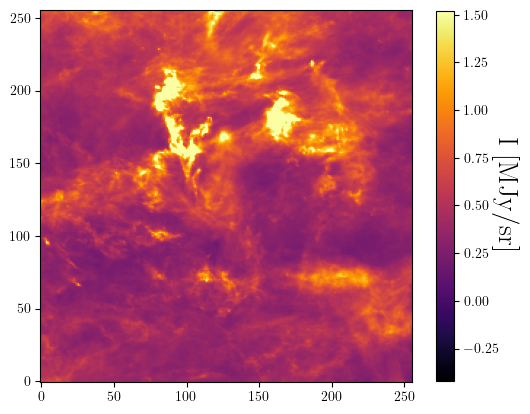

In [3]:
plot(s)

## Generate mock data

Now, we will create a noisy map and apply the component separation algorithm in order to separate the dust from the noise. \
We begin by choosing the signal-to-noise ratio of the noisy map :

In [4]:
SNR = 2

The noisy map "d" is then defined as d = s + n where "n" is the noise map with $\sigma$(s) / $\sigma$(n) = SNR.

In [5]:
d = s + np.random.normal(0,np.std(s)/SNR,size=np.shape(s)).astype(np.float64)

We can plot it :

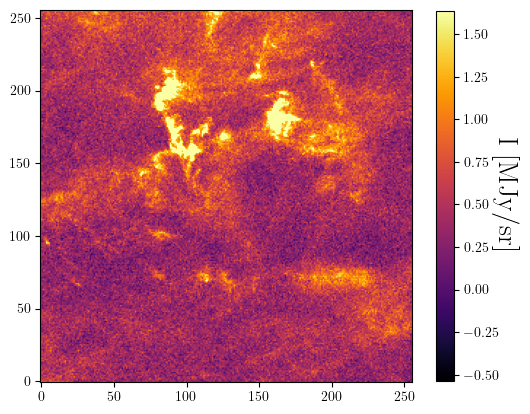

In [6]:
plot(d)

We also generate a set of "Mn" noise realizations that we will need for the component separation.

In [7]:
Mn = 20
noise = np.random.normal(0,np.std(s)/SNR,size=(Mn,np.shape(s)[0],np.shape(s)[0])).astype(np.float64)

## Choose the parameters

This algorithm contains several parameters that we present. \
Some concern the WPH statistics, while others concern the component separation algorithm itself.

### WPH statistics parameters

"N" is the size of the map. \
"J" is the number of dyadic scales to be taken into account. The largest scale in pixel is $2^{J}$. The default is $\lfloor \log_2 N \rfloor - 2$. \
"L" is the number of orientations in $[0,\pi]$. The default is 4. \
"pbc" stands for "periodic boundary conditions". The default is False but it can be set to True for periodic maps. When pbc = False, the component separation does not take into account the $2^{J-1}$ pixels border of the map. \
"dn" is the number of translations in the computation of the WPH statistics. The translations help to characterize very complex structures as long thin filaments. The default is 5. \
"wph_model" contains the WPH coefficients that will be used. The default is $[S^{11},S^{00},S^{01},C^{phase},C^{01},C^{00},L]$.

In [8]:
N, N = np.shape(s)
J = int(np.log2(N))-2
L = 4
pbc = False
dn = 5
wph_model = ["S11","S00","S01","Cphase","C01","C00","L"]

### Component separation parameters

"style" defines the formalism used for the loss computation and gradient descent in the algorithm. It can be 'JM' for Jean-Marc Delouis's formalism (see Delouis et al. 2022) or 'B' for Bruno Régaldo Saint-Blancard's formalism (see Régaldo Saint-Blancard et al. 2021). Both have their pros and cons. Jean-Marc's formalism is much more efficient in terms of computation time and often gives slightly better results in terms of statistics but it can sometimes leads to instabilities and artifacts in the maps. Bruno's formalism is slower and gives often slightly less good results in terms of statistics but is very stable and gives very realistic maps. We use style = 'JM' in this tutorial for computational reasons. The user is encouraged to test both styles. \
"method" is the optimizer used in the scipy.optimize.minimize function. The default is L-BFGS-B. \
"n_era" is the number of optimization eras. The default is 3. \
"iter_per_era" is the number of iteration in each era of optimization. The default is 30. \
"device" is the device on which the computation are done. \
"batch_size" is the number of maps in each batch. The default is 5. The value can be increased in order to speed up the algorithm but it requires more memory. 

In [26]:
style = 'JM'
method = 'L-BFGS-B'
n_era = 3
iter_per_era = 30
device = "cpu"
batch_size = 5

## Define the objective function

The objective function is the one which is minimized so that "u" converges to the estimate of "s". \
This function takes the running map as an input and computes the loss function and its gradient. 

In [30]:
def objective(x):
    """
    Computes the loss and the corresponding gradient.

    Parameters
    ----------
    x : torch 2D tensor
        Running map.

    Returns
    -------
    float
        Loss value.
    torch 1D tensor
        Gradient of the loss.

    """
    global eval_cnt
    start_time = time.time()
    u = x.reshape((N, N)) # Reshape x
    u = torch.from_numpy(u).to(device).requires_grad_(True) # Track operations on u
    if style == 'B':
        L = compute_loss_B(u, coeffs_target, std, mask, device, Mn, wph_op, noise, pbc) # Compute the loss 'à la Bruno'
    if style == 'JM':
        L = compute_loss_JM(u, coeffs_target, std, mask, device, Mn, wph_op, pbc) # Compute the loss 'à la Jean-Marc'
    u_grad = u.grad.cpu().numpy().astype(x.dtype) # Compute the gradient
    if eval_cnt % 5 == 0:
        print(f"Evaluation: {eval_cnt}")
        print("L = "+str(round(L.item(),5)))
        print("(computed in "+str(round(time.time() - start_time,3))+"s)")
        print("")
    eval_cnt += 1
    return L.item(), u_grad.ravel()

## Begin the optimization

We can now define the WPH operator that will compute the statistics. We also define batches of noise maps to speedup the computations.

In [31]:
wph_op = pw.WPHOp(N, N, J, L=L, dn=dn, device=device)
batch_number = int(Mn/batch_size)
n_batch = create_batch(noise, device, batch_number, batch_size, N)

### First step

We perform a first step of optimization in which the WPH statistics only contain power-spectrum-like terms. This allows to converge to an intermediate solution "s_tilde0" which has the proper power spectrum before adding all the WPH statistics in the loss function. 

In the gradient descent, the loss function is written in a $\chi^2$-like formalism. The standard deviations of the WPH statistics are re-evaluated at the beginning of each era. The running map is plotted at the end of each era.

Starting era 1...
Computing loss arguments...
Real mask computed : 58 % of coeffs kept !
Imaginary mask computed : 53 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 0
L = 2.11638
(computed in 0.319s)

Evaluation: 5
L = 0.12523
(computed in 0.434s)

Evaluation: 10
L = 0.0193
(computed in 0.383s)

Evaluation: 15
L = 0.00363
(computed in 0.38s)

Evaluation: 20
L = 0.00117
(computed in 0.326s)

Evaluation: 25
L = 0.0006
(computed in 0.403s)

Evaluation: 30
L = 0.00044
(computed in 0.475s)

Era 1 done !


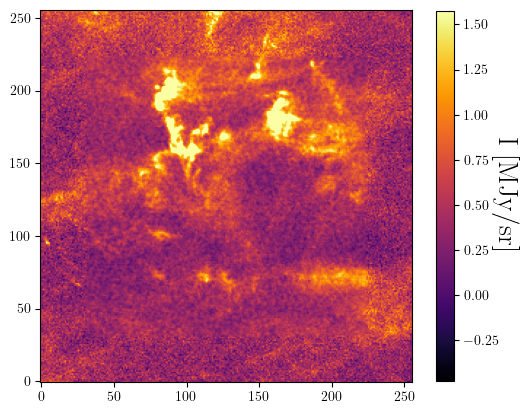

Starting era 2...
Computing loss arguments...
Real mask computed : 58 % of coeffs kept !
Imaginary mask computed : 53 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 35
L = 0.00096
(computed in 0.318s)

Evaluation: 40
L = 0.00067
(computed in 0.418s)

Evaluation: 45
L = 0.00047
(computed in 0.363s)

Evaluation: 50
L = 0.00029
(computed in 0.416s)

Evaluation: 55
L = 0.00019
(computed in 0.328s)

Evaluation: 60
L = 0.00012
(computed in 0.359s)

Evaluation: 65
L = 9e-05
(computed in 0.391s)

Era 2 done !


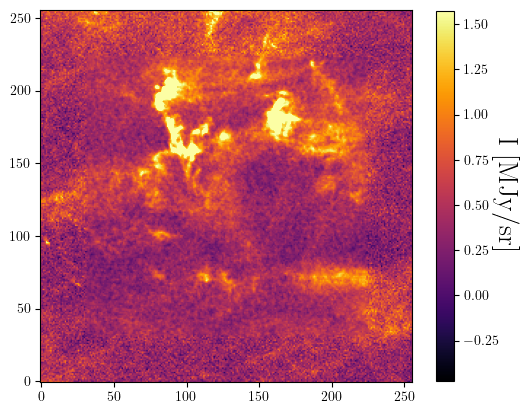

Starting era 3...
Computing loss arguments...
Real mask computed : 58 % of coeffs kept !
Imaginary mask computed : 53 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 70
L = 0.01823
(computed in 0.383s)

Evaluation: 75
L = 7e-05
(computed in 0.345s)

Evaluation: 80
L = 6e-05
(computed in 0.403s)

Evaluation: 85
L = 5e-05
(computed in 0.393s)

Evaluation: 90
L = 5e-05
(computed in 0.401s)

Evaluation: 95
L = 4e-05
(computed in 0.403s)

Evaluation: 100
L = 4e-05
(computed in 0.337s)

Era 3 done !


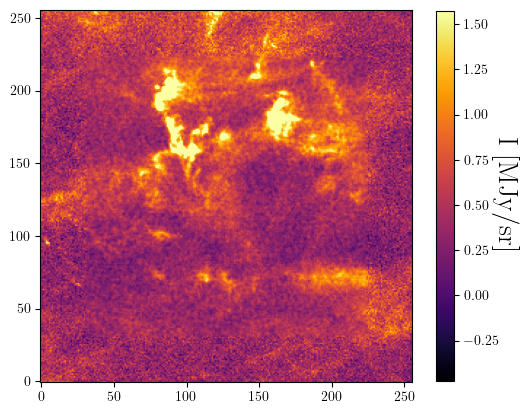

In [39]:
eval_cnt = 0
s_tilde0 = d
wph_op.load_model(["S11"])
for i in range(n_era):
    print("Starting era "+str(i+1)+"...")
    s_tilde0 = torch.from_numpy(s_tilde0).to(device)
    print('Computing loss arguments...')
    bias, std = compute_bias_std(s_tilde0, n_batch, wph_op, pbc, Mn, batch_number, batch_size, device)
    coeffs = wph_op.apply(torch.from_numpy(d).to(device), norm=None, pbc=pbc)
    if style == 'B':
        coeffs_target = torch.cat((torch.unsqueeze(torch.real(coeffs),dim=0),torch.unsqueeze(torch.imag(coeffs),dim=0)))
    if style == 'JM':
        coeffs_target = torch.cat((torch.unsqueeze(torch.real(coeffs)-bias[0],dim=0),torch.unsqueeze(torch.imag(coeffs)-bias[1],dim=0)))
    mask = compute_mask(1, s_tilde0, std, wph_op, wph_model, pbc, device)
    print('Loss arguments computed !')
    print('Beginning optimization...')
    result = opt.minimize(objective, s_tilde0.cpu().ravel(), method=method, jac=True, tol=None, options={"maxiter": iter_per_era, "gtol": 1e-14, "ftol": 1e-14, "maxcor": 20})
    final_loss, s_tilde0, niter, msg = result['fun'], result['x'], result['nit'], result['message']
    s_tilde0 = s_tilde0.reshape((N, N)).astype(np.float64)
    print("Era "+str(i+1)+" done !")
    plot(s_tilde0)

### Second step

The second step starts from the results of the first step "s_tilde0". We run the algorithm a second time but now with all the WPH statistics. 

Starting era 1...
Computing loss arguments...
Real mask computed : 49 % of coeffs kept !
Imaginary mask computed : 37 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 0
L = 1.90553
(computed in 7.269s)

Evaluation: 5
L = 0.04917
(computed in 7.409s)

Evaluation: 10
L = 0.01262
(computed in 7.322s)

Evaluation: 15
L = 0.00498
(computed in 7.36s)

Evaluation: 20
L = 0.00269
(computed in 7.415s)

Evaluation: 25
L = 0.00162
(computed in 7.409s)

Evaluation: 30
L = 0.00127
(computed in 7.224s)

Era 1 done !


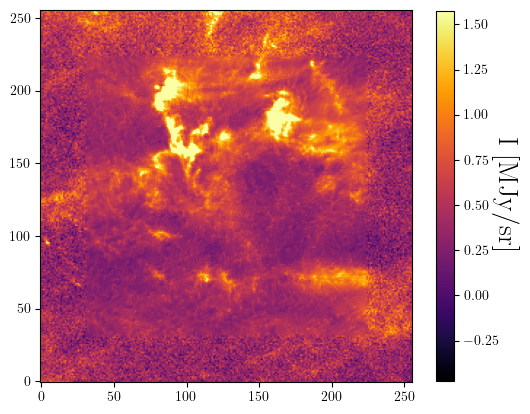

Starting era 2...
Computing loss arguments...
Real mask computed : 49 % of coeffs kept !
Imaginary mask computed : 37 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 35
L = 0.00628
(computed in 7.403s)

Evaluation: 40
L = 0.00262
(computed in 7.516s)

Evaluation: 45
L = 0.00184
(computed in 7.593s)

Evaluation: 50
L = 0.00138
(computed in 7.549s)

Evaluation: 55
L = 0.00102
(computed in 7.601s)

Evaluation: 60
L = 0.00082
(computed in 7.405s)

Era 2 done !


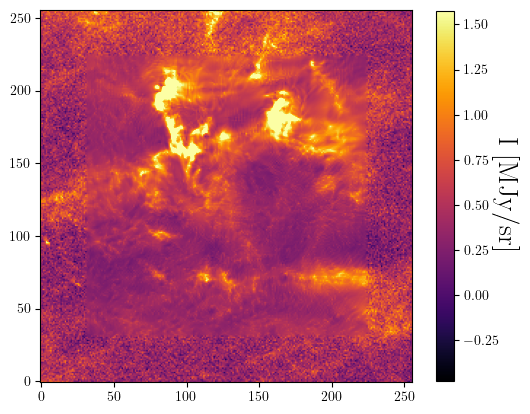

Starting era 3...
Computing loss arguments...
Real mask computed : 49 % of coeffs kept !
Imaginary mask computed : 37 % of coeffs kept !
Loss arguments computed !
Beginning optimization...
Evaluation: 65
L = 0.00334
(computed in 7.874s)

Evaluation: 70
L = 0.00143
(computed in 7.562s)

Evaluation: 75
L = 0.00116
(computed in 7.824s)

Evaluation: 80
L = 0.00105
(computed in 7.982s)

Evaluation: 85
L = 0.00092
(computed in 8.167s)

Evaluation: 90
L = 0.00083
(computed in 7.745s)

Evaluation: 95
L = 0.00075
(computed in 7.891s)

Era 3 done !


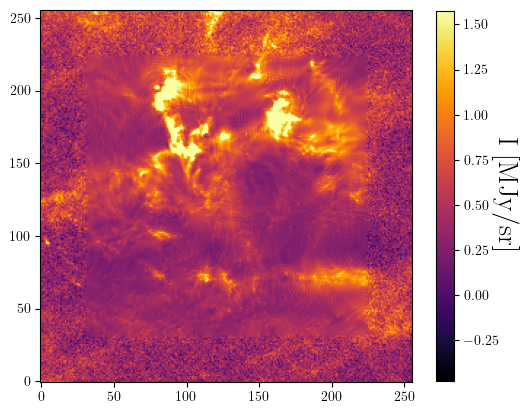

In [35]:
eval_cnt = 0
s_tilde = s_tilde0
wph_op.load_model(wph_model)
for i in range(n_era):
    print("Starting era "+str(i+1)+"...")
    s_tilde = torch.from_numpy(s_tilde).to(device)
    print('Computing loss arguments...')
    bias, std = compute_bias_std(s_tilde, n_batch, wph_op, pbc, Mn, batch_number, batch_size, device)
    coeffs = wph_op.apply(torch.from_numpy(d).to(device), norm=None, pbc=pbc)
    if style == 'B':
        coeffs_target = torch.cat((torch.unsqueeze(torch.real(coeffs),dim=0),torch.unsqueeze(torch.imag(coeffs),dim=0)))
    if style == 'JM':
        coeffs_target = torch.cat((torch.unsqueeze(torch.real(coeffs)-bias[0],dim=0),torch.unsqueeze(torch.imag(coeffs)-bias[1],dim=0)))
    mask = compute_mask(2, s_tilde, std, wph_op, wph_model, pbc, device)
    print('Loss arguments computed !')
    print('Beginning optimization...')
    result = opt.minimize(objective, s_tilde.cpu().ravel(), method=method, jac=True, tol=None, options={"maxiter": iter_per_era, "gtol": 1e-14, "ftol": 1e-14, "maxcor": 20})
    final_loss, s_tilde, niter, msg = result['fun'], result['x'], result['nit'], result['message']
    s_tilde = s_tilde.reshape((N, N)).astype(np.float64)
    print("Era "+str(i+1)+" done !")
    plot(s_tilde)

## End

We can now plot the output dust map. As the edges have not been processed by the separation, only the central part is displayed.

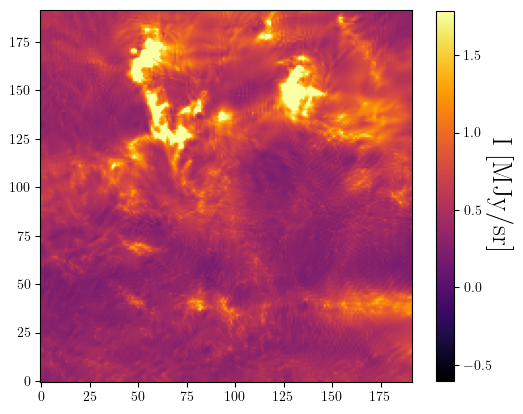

In [41]:
plot(s_tilde[2**(J-1):-2**(J-1),2**(J-1):-2**(J-1)])

This maps seems to be noise-free. It however presents some artifacts that are due to the small size of the map and to Jean-Marc's formalism. A run with a larger map on a GPU and/or in Bruno's formalism could give better results. 